In [1]:
from pyiron_contrib.workflow.function import Function

# Pyiron workflows: Introduction and Syntax

Here we will highlight:
- How to instantiate a node
- How to make reusable node classes
- How to connect node inputs and outputs together
- Flow control (i.e. signal channels vs data channels)
- Defining new nodes from special node classes (Fast and SingleValue)
- The five ways of adding nodes to a workflow
- Using pre-defined nodes 

## Instantiating a node

Simple nodes can be defined on-the-fly by passing any callable to the `Function(Node)` class. This transforms the function into a node instance which has input and output, can be connected to other nodes in a workflow, and can run the function it stores.

Input and output channels are _automatically_ extracted from the signature and return value(s) of the function. (Note: "Nodized" functions must have _at most_ one `return` expression!)

In [2]:
def plus_minus_one(x):
    return x+1, x-1

pm_node = Function(plus_minus_one)

This has automatically created a node with input and output data channels whose labels are gathered by inspecting the function:

In [3]:
print(pm_node.inputs.labels, pm_node.outputs.labels)

['x'] ['x+1', 'x-1']


The output is still empty (`NotData`) because we haven't `run()` the node:

In [4]:
print(pm_node.outputs.to_value_dict())

{'x+1': <class 'pyiron_contrib.workflow.channels.NotData'>, 'x-1': <class 'pyiron_contrib.workflow.channels.NotData'>}


If we try that now though, we'll just get a type error because the input is not set! 

In [5]:
# pm_node.run()

By default, a softer `update()` call is made at instantiation and whenever the node input is updated.
This call checks to make sure the input is `ready` before moving on to `run()`. 

If we update the input, we'll give the node enough data to work with and it will automatically update the output:

In [6]:
pm_node.inputs.x = 5
print(pm_node.outputs.to_value_dict())

{'x+1': 6, 'x-1': 4}


We can be stricter and force the node to wait for an explicit `run()` call by modifying the `run_on_updates` and `update_on_instantiation` flags. 

Let's also take the opportunity to give our output channel a better name so we can get it by dot-access.

In [7]:
def adder(x: int, y: int = 1) -> int:
    sum_ = x + y
    return sum_

adder_node = Function(adder, run_on_updates=False)
adder_node.inputs.x = 1
adder_node.outputs.sum_.value  # We use `value` to see the data the channel holds

pyiron_contrib.workflow.channels.NotData

We see that now the output did not get populated automatically when we updated `x`. 
We can still get the output by asking for it though:

In [8]:
adder_node.run()
adder_node.outputs.sum_.value

2

This node also exploits type hinting!
After turning the automatic updates back on, we can see that we can safely pass incorrect data without running into an error:

In [9]:
adder_node.run_on_updates = True
adder_node.inputs.x = "not an integer"
adder_node.inputs.x.type_hint, type(adder_node.inputs.x.value)
# No error because the update doesn't trigger a run since the type hint is not satisfied

(int, str)

But `run()` never got called, so the output is unchanged

In [10]:
adder_node.outputs.sum_.value

2

Note that assigning data to channels with `=` is actually just syntactic sugar for calling the `update` method of the underlying channel:

In [11]:
adder_node.inputs.x.update(2)
adder_node.outputs.sum_.value

3

We can also set new input as any valid combination of kwargs and/or args at both instantiation or on call:

In [12]:
adder_node(10, y=20)
adder_node.outputs.sum_.value

30

Finally, when running (or updating or calling when those result in a run -- i.e. the node is set to run on updates and is ready) a function node returns the wrapped function output directly:

In [13]:
adder_node(15, 16)

31

Note for advanced users: when the node has an executor set, running returns a futures object for the calculation, whose `.result()` will eventually be the function output.

## Reusable node classes

If we're going to use a node many times, we may want to define a new sub-class of `Function` to handle this.

The can be done directly by inheriting from `Function` and overriding it's `__init__` function so that the core functionality of the node (i.e. the node function and output labels) are set in stone, but even easier is to use the `function_node` decorator to do this for you!

The decorator takes the output labels and whatever other class kwargs you want to override, and the function is defined like any other node function:

In [14]:
from pyiron_contrib.workflow.function import function_node

In [15]:
@function_node()
def subtract_node(x: int | float = 2, y: int | float = 1) -> int | float:
    diff = x - y
    return diff

sn = subtract_node()
print("class name =", sn.__class__.__name__)
print("label =", sn.label)
print("default output =", sn.outputs.diff.value)

class name = SubtractNode
label = subtract_node
default output = 1


Earlier we saw that we could set input data by function defaults, or by directly setting the `.inputs.*` channel values with an `=` assignement or `.update` method call.

We can also set the input of a node instance at instantiation by passing the input labels as kwargs!

In [16]:
subtract_node(10, 20).outputs.diff.value

-10

## Node connections 

Next, we want to make connections between nodes. Instead of `update` we can use the `connect` method to accomplish this, or we can do it with the other syntactic sugar we saw for regular data (i.e. direct attribute access or using kwargs at instantiation):

In [17]:
@function_node()
def add_node(x: int | float = 1, y: int | float = 1) -> int | float:
    sum_ = x + y
    return sum_

add1 = add_node()
add2 = add_node(2, 2)
sub = subtract_node(x=add1.outputs.sum_, y=add2.outputs.sum_)
print(
    f"{add1.outputs.sum_.value} - {add2.outputs.sum_.value} = {sub.outputs.diff.value}"
)

2 - 4 = -2


Because we've set all of our nodes to run automatically on updates, we can change upstream data and see the result propogate downstream immediately:

In [18]:
add1.inputs.x = 10
print(
    f"{add1.outputs.sum_.value} - {add2.outputs.sum_.value} = {sub.outputs.diff.value}"
)

11 - 4 = 7


## Special nodes

In addition to the basic `Function` class, for the sake of convenience we also offer `Slow(Function)` -- which changes the defaults of `run_on_updates` and `update_on_instantiation` to `False` so that `run()` calls are necessary -- this can be helpful for nodes that are computationally expensive; and `SingleValue(Function)` -- which enforces that there is only a _single_ return value to the node function (i.e. a single output label), and then lets attribute and item access fall back to looking for attributes and items of this single output value. Of course there are decorators available for both of these.

Let's look at a use case:

In [19]:
import numpy as np

from pyiron_contrib.workflow.function import single_value_node

In [20]:
@single_value_node()
def linspace_node(
    start: int | float = 0, stop: int | float = 1, num: int = 50
):
    linspace = np.linspace(start=start, stop=stop, num=num)
    return linspace

lin = linspace_node()

print(type(lin.outputs.linspace.value))  # Output is just what we expect
print(lin[1:4])  # Gets items from the output
print(lin.mean())  # Finds the method on the output -- a special feature of SingleValueNode

<class 'numpy.ndarray'>
[0.02040816 0.04081633 0.06122449]
0.5


# Flow control

By default, when a node runs and updates its output, this triggers outputs in all downstream connections. This is useful when all your node functions are small and light, but there may come times when you want something other than this simple "push" flow.

In addition to input and output data channels, nodes also have "signal" channels available. Input signals are bound to a callback function (typically one of its node's methods), and output signals trigger the callbacks for all the input signal channels they're connected to.

Standard nodes have a `run` input signal (which is, unsurprisingly, bound to the `run` method), and a `ran` output signal (which, again, hopefully with no great surprise, is triggered at the end of the `run` method.)

Below is a super simple example of how these signal channels can be used to delay execution and manually control flow:

In [21]:
@function_node()
def linear(x):
    return x

@function_node(run_on_updates=False)
def times_two(x):
    double = 2 * x
    return double

l = linear(x=1)
t2 = times_two(x=l.outputs.x)
print(t2.inputs.x, t2.outputs.double)

1 <class 'pyiron_contrib.workflow.channels.NotData'>


Now the input of `t2` got updated when the connection is made, but by we told this node not to do any automatic updates, so the output has its uninitialized value of `NotData`.

Often, you will want to have nodes with data connections to have signal connections, but this is not strictly required. Here, we'll introduce a (not strictly necessary) third node to control starting the workflow, and chain together to signals from our two functional nodes.

Note that we have all the same syntacic sugar from data channels when creating connections between signal channels.

In [22]:
@function_node()
def control():
    return

c = control()
l.signals.input.run = c.signals.output.ran
t2.signals.input.run = l.signals.output.ran
c.run()
print(t2.outputs.double.value)

2


`Function` and its children always push out data updates _before_ triggering their `ran` signal.

It is also possible to flag certain inputs channels so they require updates after each time their node is run before they are `ready` again. These can be defined either at the node instantiation, or after the fact using a method on the channel. Both approaches are shown in the example below:

In [23]:
import matplotlib.pyplot as plt

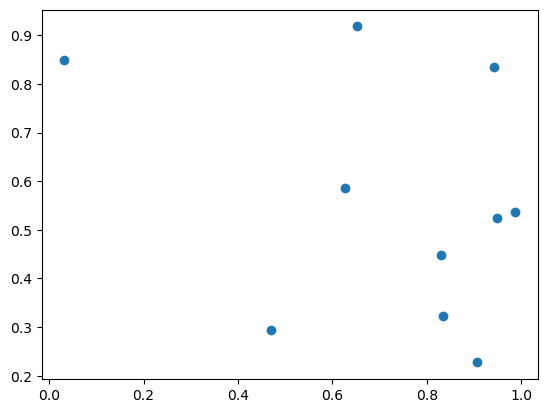

In [24]:
@single_value_node()
def noise(length: int = 1):
    array =  np.random.rand(length)
    return array

@function_node()
def plot(x, y):
    fig = plt.scatter(x, y)
    return fig

x = noise(length=10)
y = noise(length=10)
f = plot(
    x=x, 
    y=y,
    channels_requiring_update_after_run=["x"],
)
f.inputs.y.require_update_after_node_runs(wait_now=True)

Now that the plotting node has run, its input channels are no longer `ready` because they are waiting for a fresh update:

In [25]:
f.inputs.x.ready, f.inputs.y.ready

(False, False)

In [26]:
x.inputs.length = 20
f.inputs.x.ready, f.inputs.y.ready

(True, False)

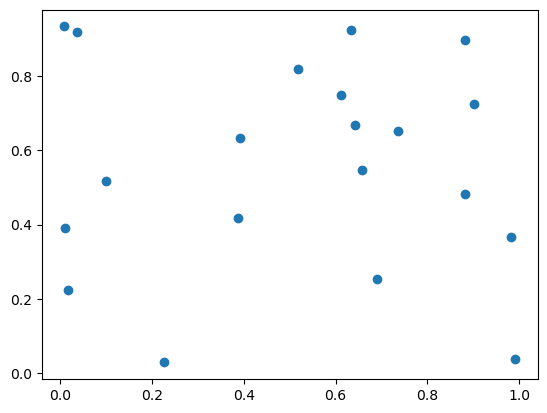

In [27]:
y.inputs.length = 20

Note that in the second cell, `f` is trying to update itself as soon as its inputs are ready, so if we _hadn't_ set the `f.inputs.y` channel to wait for an update, we would have gotten an error from the plotting command due to the mis-matched lengths of the x- and y-arrays.

# Workflows

The case where we have groups of connected nodes working together is our normal, intended use case.
We offer a formal way to group these objects together as a `Workflow(Node)` object.
`Workflow` also offers us a single point of entry to the codebase -- i.e. most of the time you shouldn't need the node imports used above, because the decorators are available right on the workflow class.

We will also see here that we can our node output channels using the `output_labels: Optional[str | list[str] | tuple[str]` kwarg, in case they don't have a convenient name to start with.
This way we can always have convenient dot-based access (and tab completion) instead of having to access things by string-based keys.

In [28]:
from pyiron_contrib.workflow.workflow import Workflow

@Workflow.wrap_as.single_value_node(output_labels="is_greater")
def greater_than_half(x: int | float | bool = 0) -> bool:
    """The functionality doesn't matter here, it's just an example"""
    return x > 0.5

## Adding nodes to a workflow

All five of the following approaches are equivalent ways to add a node to a workflow:

In [29]:
from pyiron_contrib.workflow.function import Slow

n1 = greater_than_half(label="n1")

wf = Workflow("my_wf", n1)  # As args at init
wf.add.Slow(lambda: x + 1, output_labels="p1", label="n2")  # Instantiating from the class with a lambda function
# (Slow since we don't have an x default)
wf.add(greater_than_half(label="n3"))  # Instantiating then passing to node adder
wf.n4 = greater_than_half(label="will_get_overwritten_with_n4")  # Set attribute to instance
greater_than_half(label="n5", parent=wf)  # By passing the workflow to the node

for k, v in wf.nodes.items():
    print(k, v.label, v)

n1 n1 n1 (GreaterThanHalf) output single-value: False
n3 n3 n3 (GreaterThanHalf) output single-value: False
n4 n4 n4 (GreaterThanHalf) output single-value: False
n5 n5 n5 (GreaterThanHalf) output single-value: False


Workflows have inputs and outputs just like function nodes, but these are dynamically created to map to all _unconnected_ input and output for their underlying graph:

In [30]:
wf = Workflow("simple")

@Workflow.wrap_as.single_value_node()
def add_one(x):
    y = x + 1
    return y

wf.a = add_one(0)
wf.b = add_one(0)
wf.sum = add_node(wf.a, wf.b)  
# Remember, with single value nodes we can pass the whole node instead of an output channel!

print(wf.outputs.sum_sum_.value)

2


/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label sum_ to the io key sum_sum_
  warn(


Unlike function nodes, workflow input has no intrinsic order. We can still update it by calling the workflow, but we _need_ to use keyword and not positional arguments. Runs of the workflow (which typically happen when the workflow is updated or called) return a dot-accessible dictionary based on the output channels:

In [31]:
out = wf(a_x=2, b_x=3)
out

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label x to the io key a_x
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label x to the io key b_x
  warn(


{'sum_sum_': 7}

In [32]:
out.sum_sum_

7

(Note, you might see warnings from the workflow IO. This is fine, it's just letting us know that its keys don't match up with the channel labels. We don't see it until we call the input because workflows generate their IO panels dynamically on request to account for the fact that connections may change.)

# Example with pre-built nodes

Currently we have a handfull of pre-build nodes available for import from the `nodes` package. Let's use these to quickly put together a workflow for looking at some MD data.

The `calc_md` node is `Slow`, but we happen to know that the calculation we're doing here is very easy, so we'll manually set `run_on_updates` and `update_at_instantiation` to `True` to get it to behave like a typical `Function` node.

Finally, `SingleValue` has one more piece of syntactic sugar: when you're making a connection to the (single!) output channel, you can just pass the node itself!

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:311: UserWarning: Reassigning the node bulk to the label structure when adding it to the parent with_prebuilt.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:311: UserWarning: Reassigning the node lammps to the label engine when adding it to the parent with_prebuilt.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 9558


/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:311: UserWarning: Reassigning the node calc_md to the label calc when adding it to the parent with_prebuilt.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:311: UserWarning: Reassigning the node scatter to the label plot when adding it to the parent with_prebuilt.
  warn(


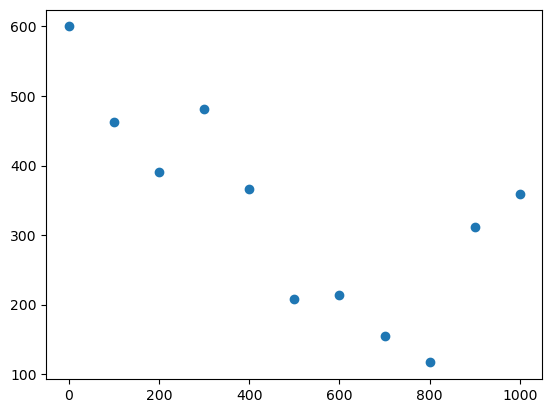

In [33]:
wf = Workflow("with_prebuilt")

wf.structure = wf.add.atomistics.Bulk(cubic=True, name="Al")
wf.engine = wf.add.atomistics.Lammps(structure=wf.structure)
wf.calc = wf.add.atomistics.CalcMd(
    job=wf.engine, 
    run_on_updates=True, 
    update_on_instantiation=True
)
wf.plot = wf.add.standard.Scatter(
    x=wf.calc.outputs.steps, 
    y=wf.calc.outputs.temperature
)

Nodes and workflows can be visualized using graphviz:

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label name to the io key structure_name
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label crystalstructure to the io key structure_crystalstructure
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label a to the io key structure_a
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label c to the io key structure_c
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label covera to the io key structure_covera
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label u to the io key structure_u
  warn(
/Users

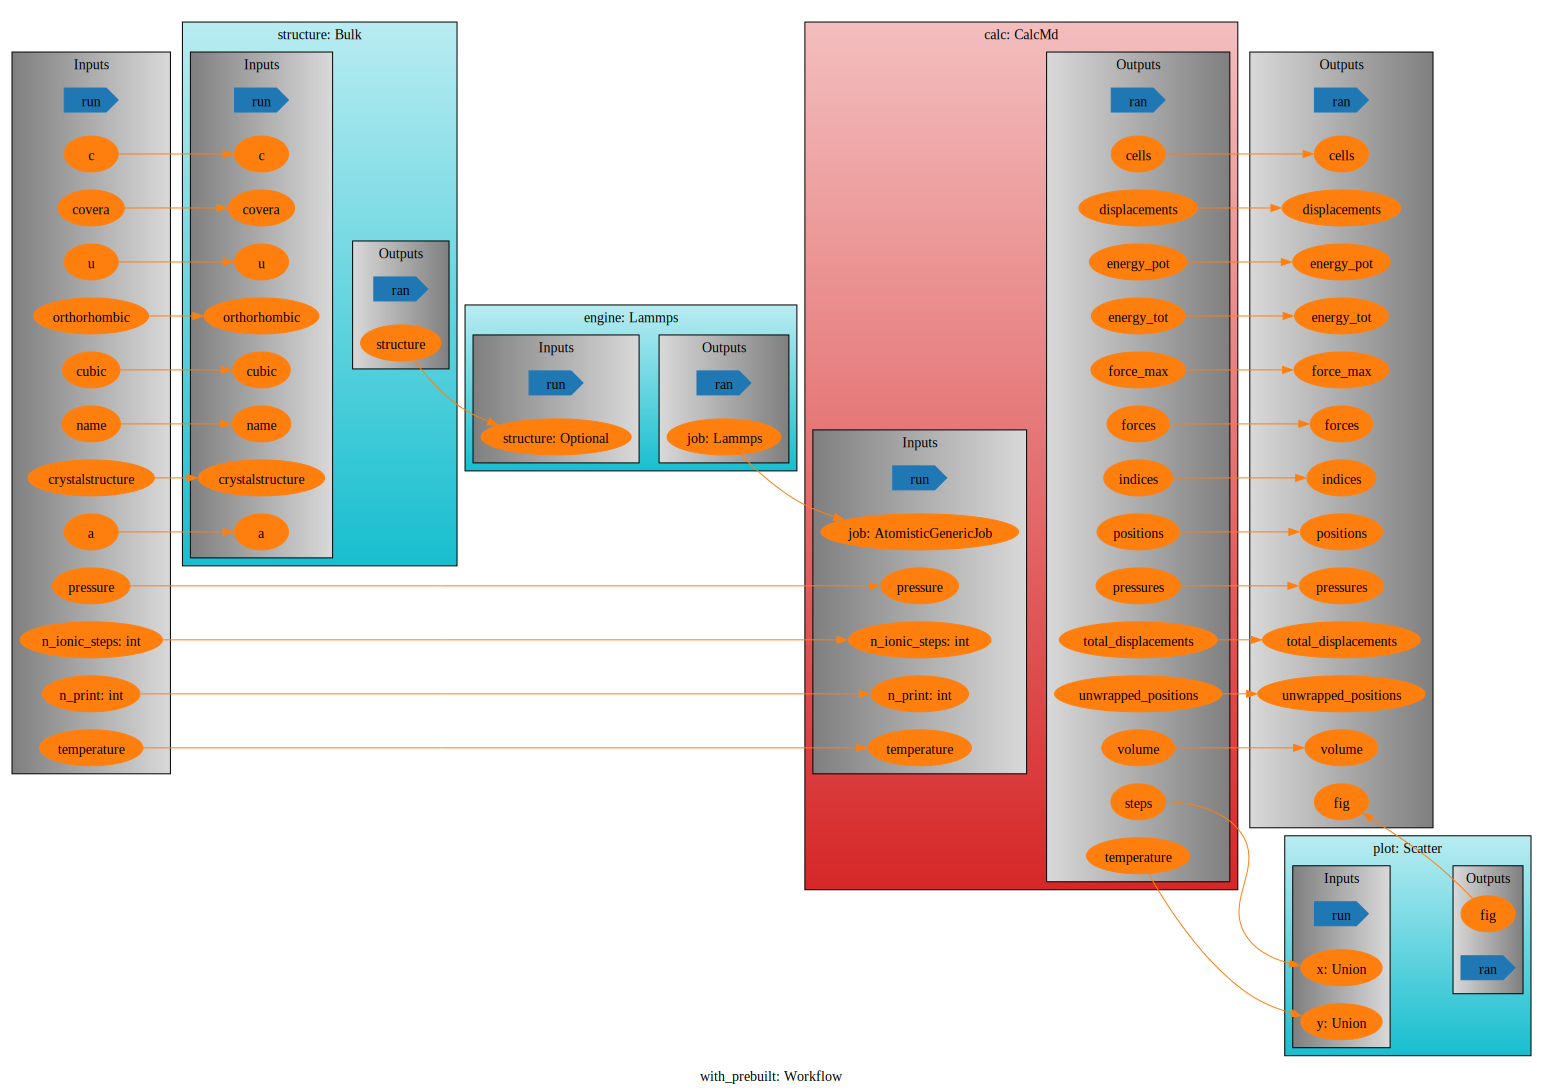

In [34]:
wf.draw()

In case you want to see more or less of the inner workings of the nodes, you can modify the `depth` parameter, which controls how deeply child nodes are decomposed. E.g. we can force our workflow to only show us it's basic IO by setting `depth=0`:

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label name to the io key structure_name
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label crystalstructure to the io key structure_crystalstructure
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label a to the io key structure_a
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label c to the io key structure_c
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label covera to the io key structure_covera
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label u to the io key structure_u
  warn(
/Users

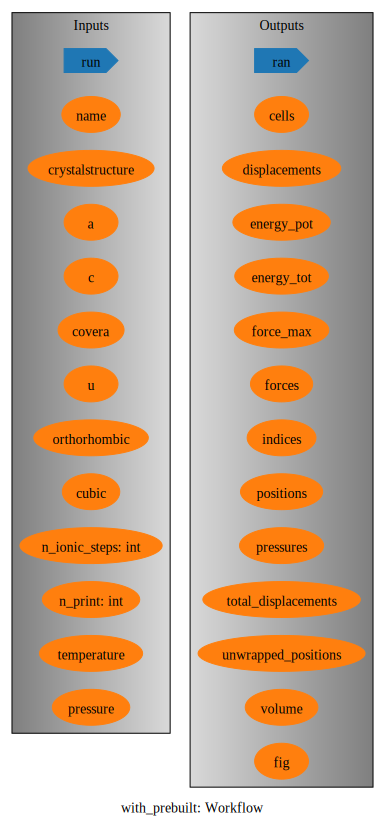

In [35]:
wf.draw(depth=0)

# Macros

Once you have a workflow that you're happy with, you may want to store it as a macro so it can be stored in a human-readable way, reused, and shared. Automated conversion of an existing `Workflow` instance into a `Macro` subclass is still on the TODO list, but defining a new macro is pretty easy: they are just composite nodes that have a function defining their graph setup:

In [36]:
from pyiron_contrib.workflow.macro import Macro

In [37]:
@Workflow.wrap_as.single_value_node()
def add_one(x):
    result = x + 1
    return result

def add_three_macro(macro: Macro) -> None:
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    macro.add_one = add_one(0)
    macro.add_two = add_one(macro.add_one)
    macro.add_three = add_one(macro.add_two)
    macro.starting_nodes = [macro.add_one]  
    # Setting this starting node is silly, since as the head-most node it would 
    # have been the starting node anyway; the point is you have access to the 
    # macro object and can do these sorts of setup proceedures here
    
macro = Macro(add_three_macro)
macro(add_one_x=10).add_three_result

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label x to the io key add_one_x
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label result to the io key add_three_result
  warn(


13

Of course, we can also use a decorator like for other node types. This is shown below, along with an example of how exploit label maps to give our macro IO easier-to-use names (and expose IO that would be skipped by default because it's internally connected):

In [38]:
@Workflow.wrap_as.macro_node()
def add_three_macro(macro: Macro) -> None:
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    macro.add_one = add_one(0)
    macro.add_two = add_one(macro.add_one)
    macro.add_three = add_one(macro.add_two)
    macro.inputs_map = {"add_one_x": "x"}
    macro.outputs_map = {"add_three_result": "plus_three", "add_two_result": "intermediate"}
    
macro = add_three_macro(x=100)
macro.outputs.to_value_dict()

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label result to the io key intermediate
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label result to the io key plus_three
  warn(


{'intermediate': 102, 'plus_three': 103}

## Nesting

Composite nodes can be nested to abstract workflows into simpler components -- i.e. macros can be added to workflows, and macros can be used inside of macros.

For our final example, let's define a macro for doing Lammps minimizations, then use this in a workflow to compare energies between different phases.

In [39]:
@Workflow.wrap_as.macro_node()
def lammps_minimize(macro):
    macro.structure = macro.add.atomistics.Bulk(run_on_updates=False)
    macro.engine = macro.add.atomistics.Lammps(structure=macro.structure, run_on_updates=False)
    macro.calc = macro.add.atomistics.CalcMin(job=macro.engine, pressure=0)
    
    macro.engine.signals.input.run = macro.structure.signals.output.ran
    macro.calc.signals.input.run = macro.engine.signals.output.ran
    
    macro.inputs_map = {
        "structure_name": "element", 
        "structure_crystalstructure": "crystalstructure",
        "structure_a": "lattice_guess",
    }
    macro.outputs_map = {
        "calc_energy_pot": "energy",
        "structure_structure": "structure",
    }
    
    # macro.starting_nodes = [macro.structure]
    # Note: We _could_ customize macro features like the starting nodes here.
    #  For this particular case we don't need to, since macro.structure will 
    #  be automatically detected as the "upstream-most" node, since it receives
    #  no input from any other nodes belonging to this macro.

@Workflow.wrap_as.single_value_node()
def per_atom_energy_difference(structure1, energy1, structure2, energy2):
    de = (energy2[-1]/len(structure2)) - (energy1[-1]/len(structure1))
    return de

In [40]:
wf = Workflow("phase_preference")
wf.element = wf.add.standard.UserInput()
wf.min_phase1 = lammps_minimize(element=wf.element)
wf.min_phase2 = lammps_minimize(element=wf.element)
wf.compare = per_atom_energy_difference(
    wf.min_phase1.outputs.structure,
    wf.min_phase1.outputs.energy,
    wf.min_phase2.outputs.structure,
    wf.min_phase2.outputs.energy,
)

wf.min_phase1.signals.input.run = wf.element.signals.output.ran
wf.min_phase2.signals.input.run = wf.element.signals.output.ran
# We stopped all the elements inside lammps_minimize from running on update
# So we'll need to hit the macro with an explicit run command

wf.inputs_map = {
    "element_user_input": "element",
    "min_phase1_crystalstructure": "phase1",
    "min_phase2_crystalstructure": "phase2",
    "min_phase1_lattice_guess": "lattice_guess1",
    "min_phase2_lattice_guess": "lattice_guess2",
}

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:311: UserWarning: Reassigning the node user_input to the label element when adding it to the parent phase_preference.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:311: UserWarning: Reassigning the node bulk to the label structure when adding it to the parent lammps_minimize.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:311: UserWarning: Reassigning the node lammps to the label engine when adding it to the parent lammps_minimize.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/composite.py:311: UserWarning: Reassigning the node calc_min to the label calc when adding it to the parent lammps_minimize.
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label name to the io key element
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_c

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label user_input to the io key element
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label crystalstructure to the io key phase1
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label a to the io key lattice_guess1
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label c to the io key min_phase1_structure_c
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label covera to the io key min_phase1_structure_covera
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label u to the io key min_phase1_structure_u

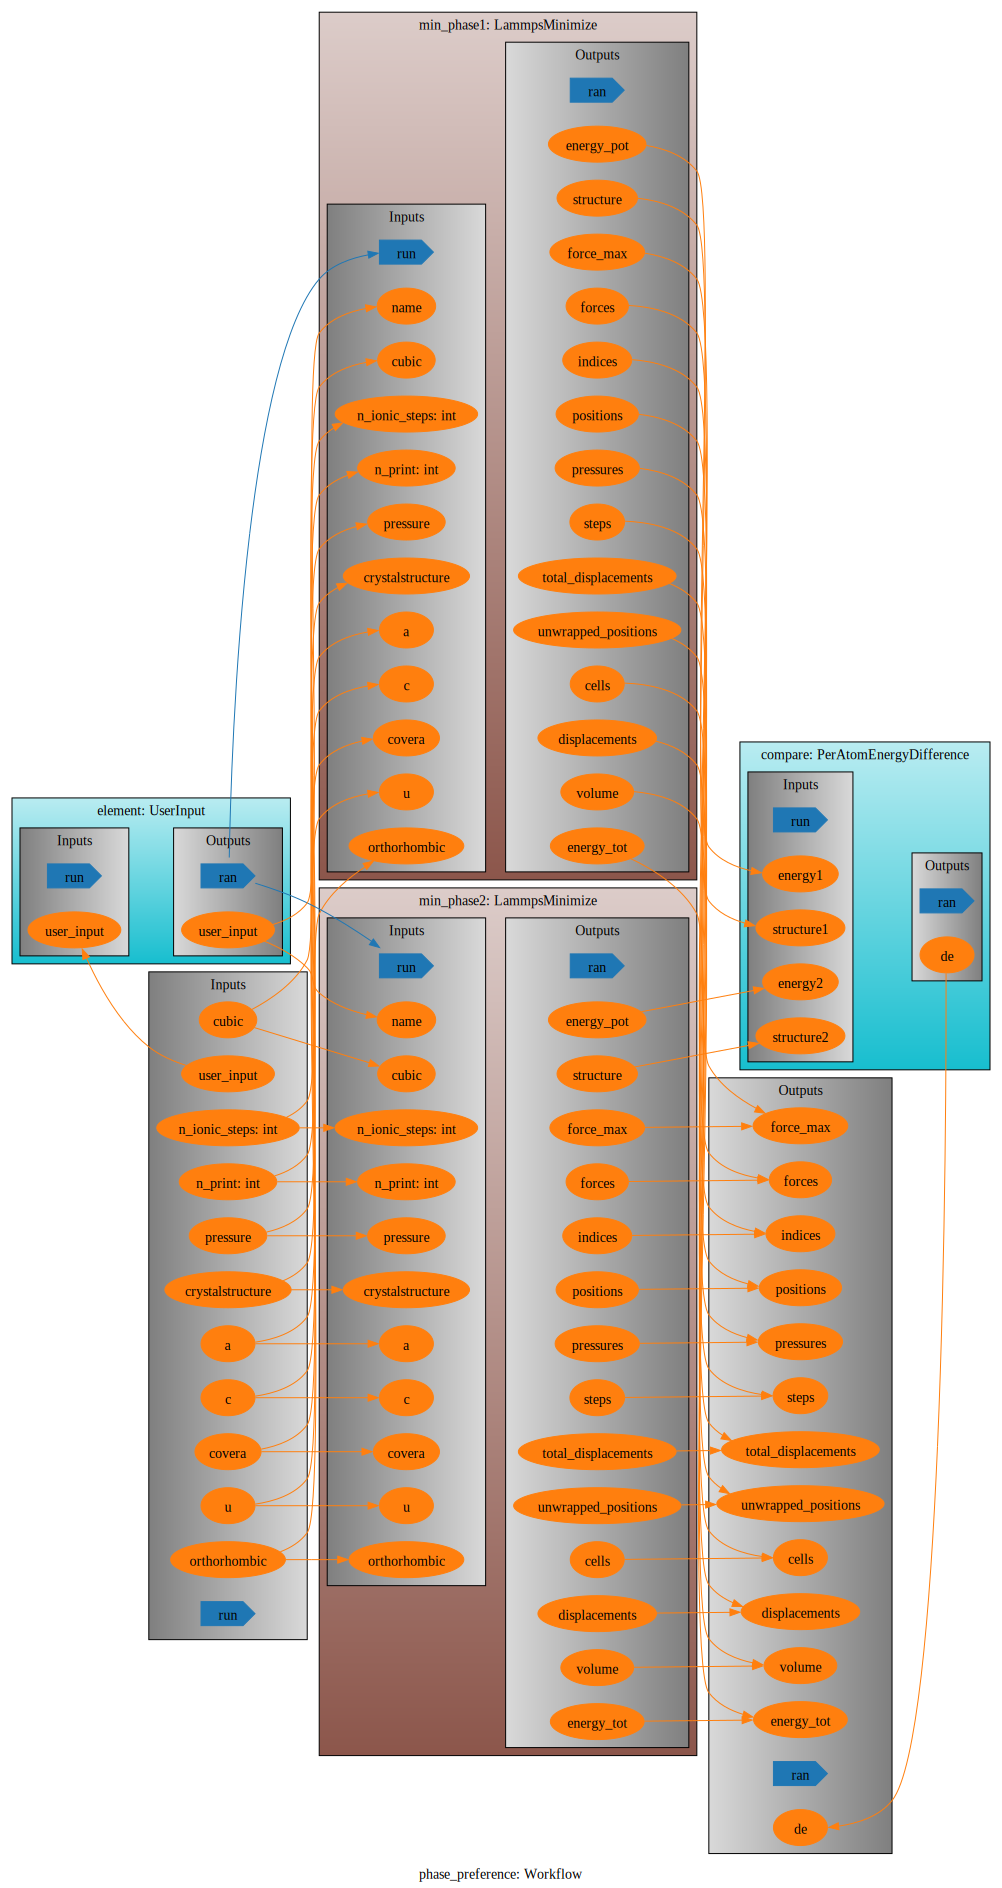

In [41]:
wf.draw()

In [42]:
out = wf(element="Al", phase1="fcc", phase2="hcp", lattice_guess1=4, lattice_guess2=4)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare_de:.2f} eV/atom")

/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label user_input to the io key element
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label crystalstructure to the io key phase1
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label a to the io key lattice_guess1
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label c to the io key min_phase1_structure_c
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label covera to the io key min_phase1_structure_covera
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label u to the io key min_phase1_structure_u

The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558


/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label user_input to the io key element
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label crystalstructure to the io key phase1
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label a to the io key lattice_guess1
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label c to the io key min_phase1_structure_c
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label covera to the io key min_phase1_structure_covera
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label u to the io key min_phase1_structure_u

The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558
Al: E(hcp) - E(fcc) = 1.17 eV/atom


/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label cells to the io key min_phase1_calc_cells
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label displacements to the io key min_phase1_calc_displacements
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label energy_tot to the io key min_phase1_calc_energy_tot
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label force_max to the io key min_phase1_calc_force_max
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label forces to the io key min_phase1_calc_forces
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a chann

In [43]:
out = wf(element="Mg", phase1="fcc", phase2="hcp", lattice_guess1=3, lattice_guess2=3)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare_de:.2f} eV/atom")

The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558


/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label user_input to the io key element
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label crystalstructure to the io key phase1
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label a to the io key lattice_guess1
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label c to the io key min_phase1_structure_c
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label covera to the io key min_phase1_structure_covera
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label u to the io key min_phase1_structure_u

The job JUSTAJOBNAME was saved and received the ID: 9558
The job JUSTAJOBNAME was saved and received the ID: 9558
Mg: E(hcp) - E(fcc) = -4.54 eV/atom


/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label cells to the io key min_phase1_calc_cells
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label displacements to the io key min_phase1_calc_displacements
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label energy_tot to the io key min_phase1_calc_energy_tot
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label force_max to the io key min_phase1_calc_force_max
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a channel with the label forces to the io key min_phase1_calc_forces
  warn(
/Users/huber/work/pyiron/pyiron_contrib/pyiron_contrib/workflow/io.py:87: UserWarning: Assigning a chann